✅ Using 1 GPU(s) with memory growth
🚀 Starting Optimized CIFAR-10 Classification Experiment
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Data prepared with TF Datasets optimization.

=== Training SimpleCNN ===
Training SimpleCNN...
Epoch 1/30
175/175 - 38s - 219ms/step - accuracy: 0.4202 - loss: 1.6806 - val_accuracy: 0.1114 - val_loss: 3.2485 - learning_rate: 1.0000e-03
Epoch 2/30
175/175 - 1s - 3ms/step - accuracy: 0.4570 - loss: 1.4473 - val_accuracy: 0.1068 - val_loss: 3.2272 - learning_rate: 1.0000e-03
Epoch 3/30
175/175 - 22s - 124ms/step - accuracy: 0.5762 - loss: 1.1905 - val_accuracy: 0.3966 - val_loss: 1.7399 - learning_rate: 1.0000e-03
Epoch 4/30
175/175 - 1s - 3ms/step - accuracy: 0.6445 - loss: 1.0046 - val_accuracy: 0.3820 - val_loss: 1.7978 - learning_rate: 1.0000e-03
Epoch 5/30
175/175 - 21s - 120ms/step - accuracy: 0.6434 - loss: 1.0110 - val_accuracy: 0.7124 - val_loss: 0.8477 - learning_rate: 1.0000e-03
Epoch 6/30
175/175 - 1s - 3ms

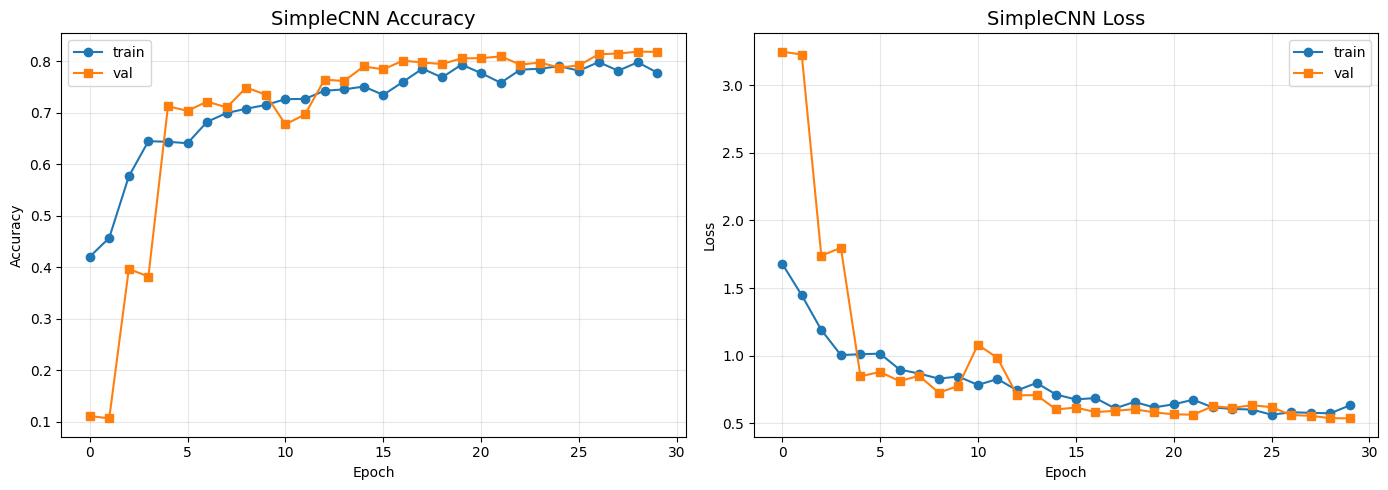

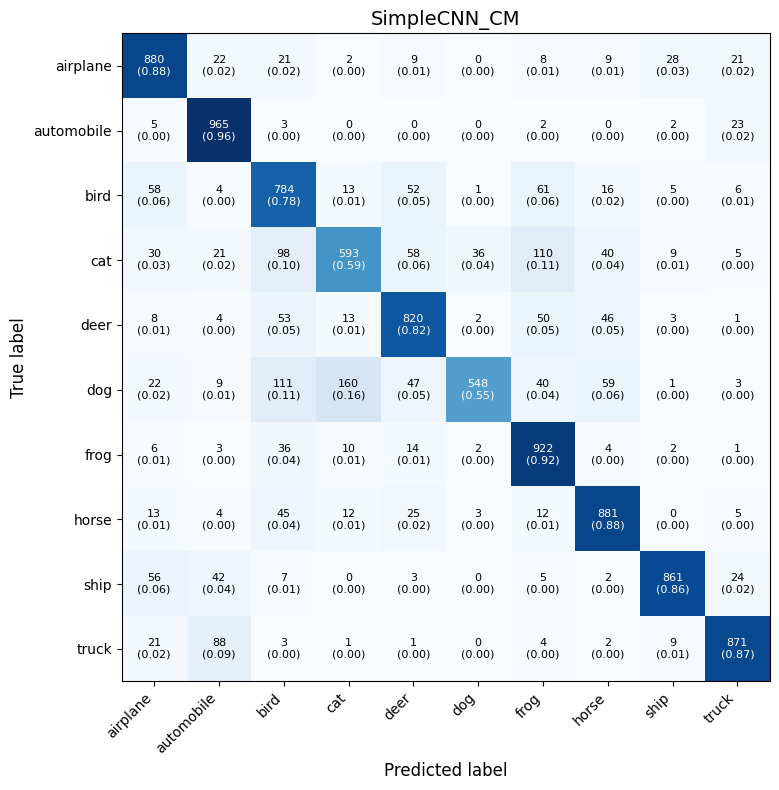

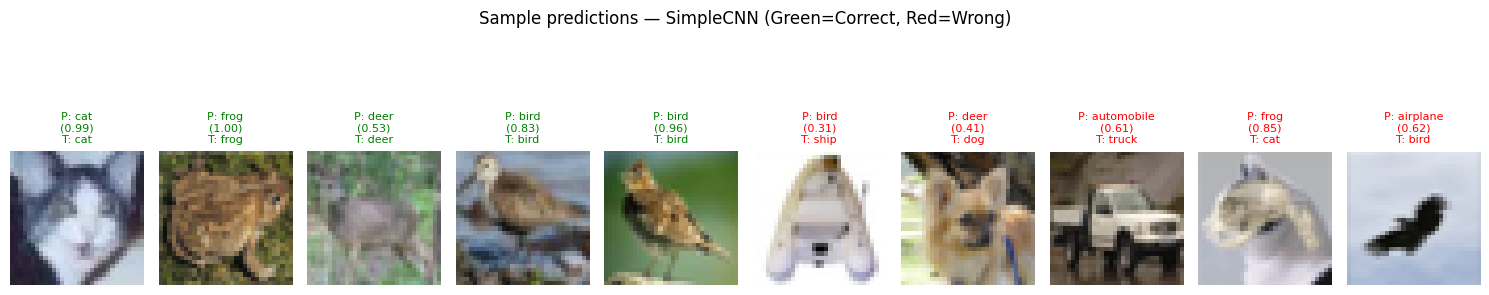


=== Training VGG_Like ===
Training VGG_Like...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
175/175 - 52s - 294ms/step - accuracy: 0.3246 - loss: 1.8322 - val_accuracy: 0.4948 - val_loss: 1.4000 - learning_rate: 1.0000e-03
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 - 1s - 5ms/step - accuracy: 0.4570 - loss: 1.5635 - val_accuracy: 0.4752 - val_loss: 1.4497 - learning_rate: 1.0000e-03
Epoch 3/30
175/175 - 22s - 124ms/step - accuracy: 0.4695 - loss: 1.4552 - val_accuracy: 0.5530 - val_loss: 1.2564 - learning_rate: 1.0000e-03
Epoch 4/30
175/175 - 1s - 5ms/step - accuracy: 0.5273 - loss: 1.3332 - val_accuracy: 0.5618 - val_loss: 1.2218 - learning_rate: 1.0000e-03
Epoch 5/30
175/175 - 22s - 125ms/step - accuracy: 0.5480 - loss: 1.2622 - val_accuracy: 0.6284 - val_loss: 1.0328 - learning_rate: 1.0000e-03
Epoch 6/30
175/175 - 1s - 5ms/step - accuracy: 0.5156 - loss: 1.3632 - val_accuracy: 0.6360 - val_loss: 1.0271 - learning_rate: 1.0000e-03
Epoch 7/30
175/175 - 22s - 128ms/step - accuracy: 0.5892 - loss: 1.1647 - val_accuracy: 0.6426 - val_loss: 1.0093 - learning_rate: 1.0000e-03
Epoch 8/30
175/175 - 1s - 5ms/step - accuracy: 0.6172 - loss: 1.1013 - val_accuracy: 0.6438 - val_loss: 0.9951 - learning_rate: 1.0000e-03
Epoch 9/30
175/175 - 21s - 12

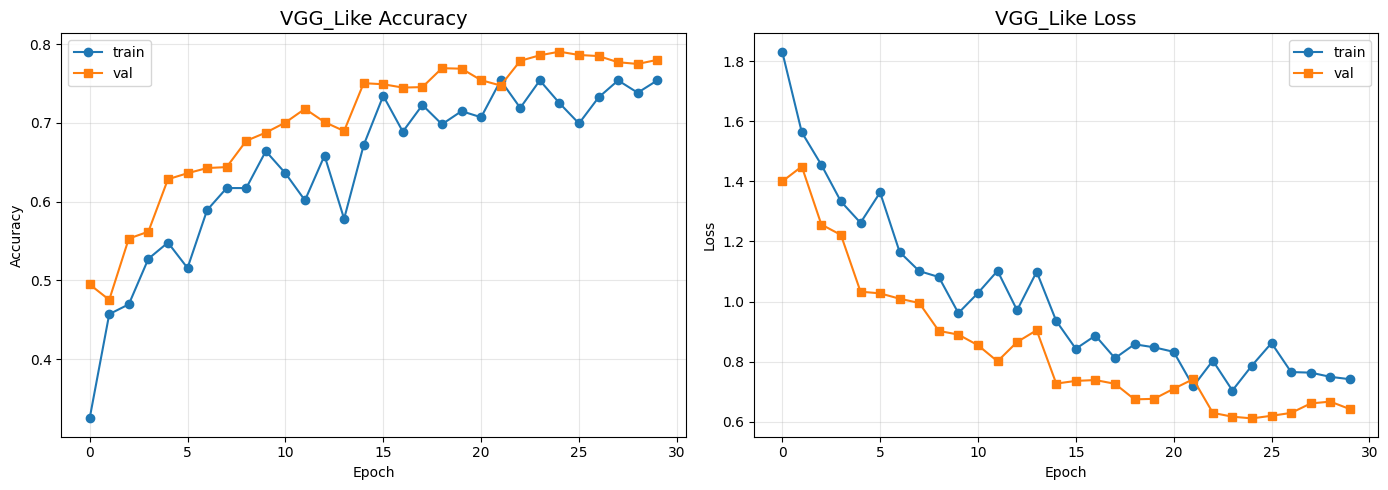

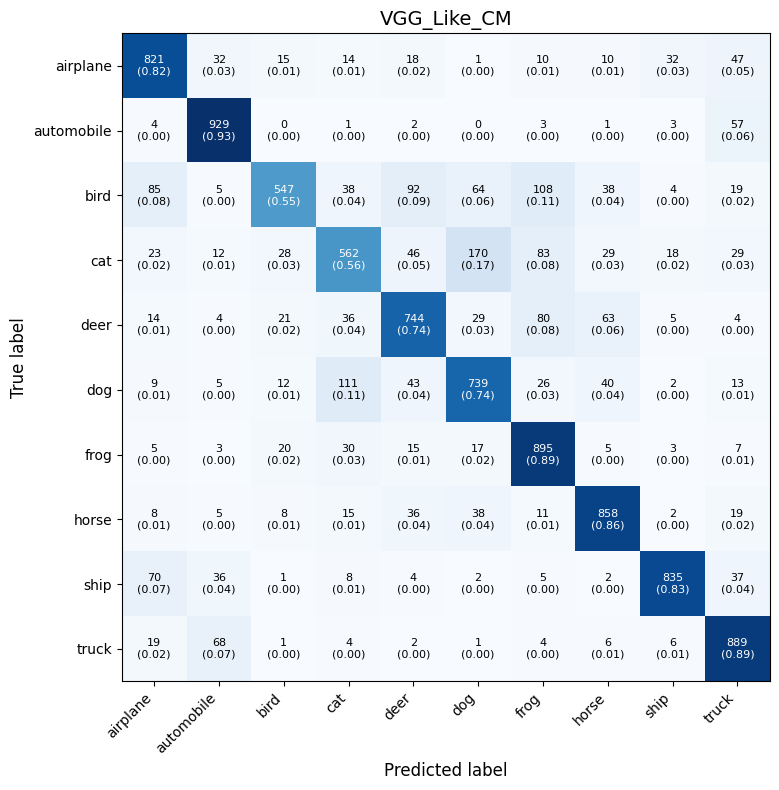

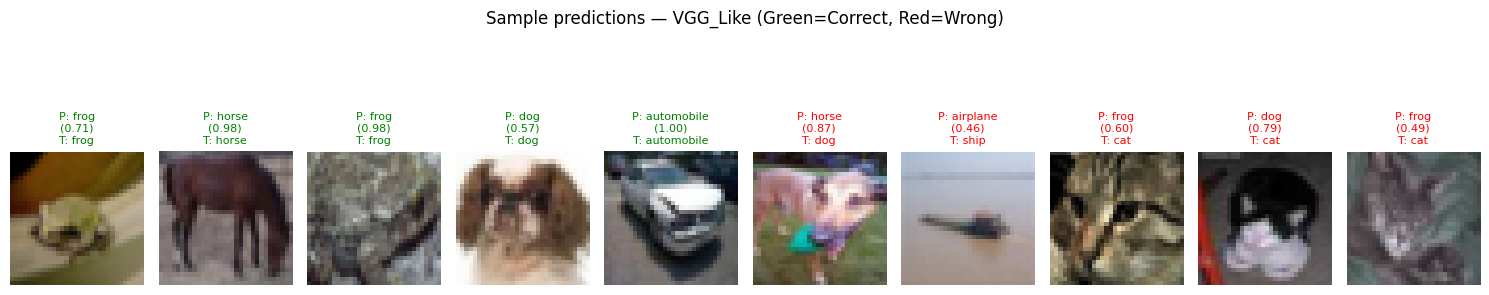


=== FINAL SUMMARY ===
       Model Accuracy Precision  Recall F1-Score Test Loss
1  SimpleCNN   0.8125    0.8201  0.8125   0.8085    0.5564
2   VGG_Like   0.7819    0.7841  0.7819   0.7777    0.6427


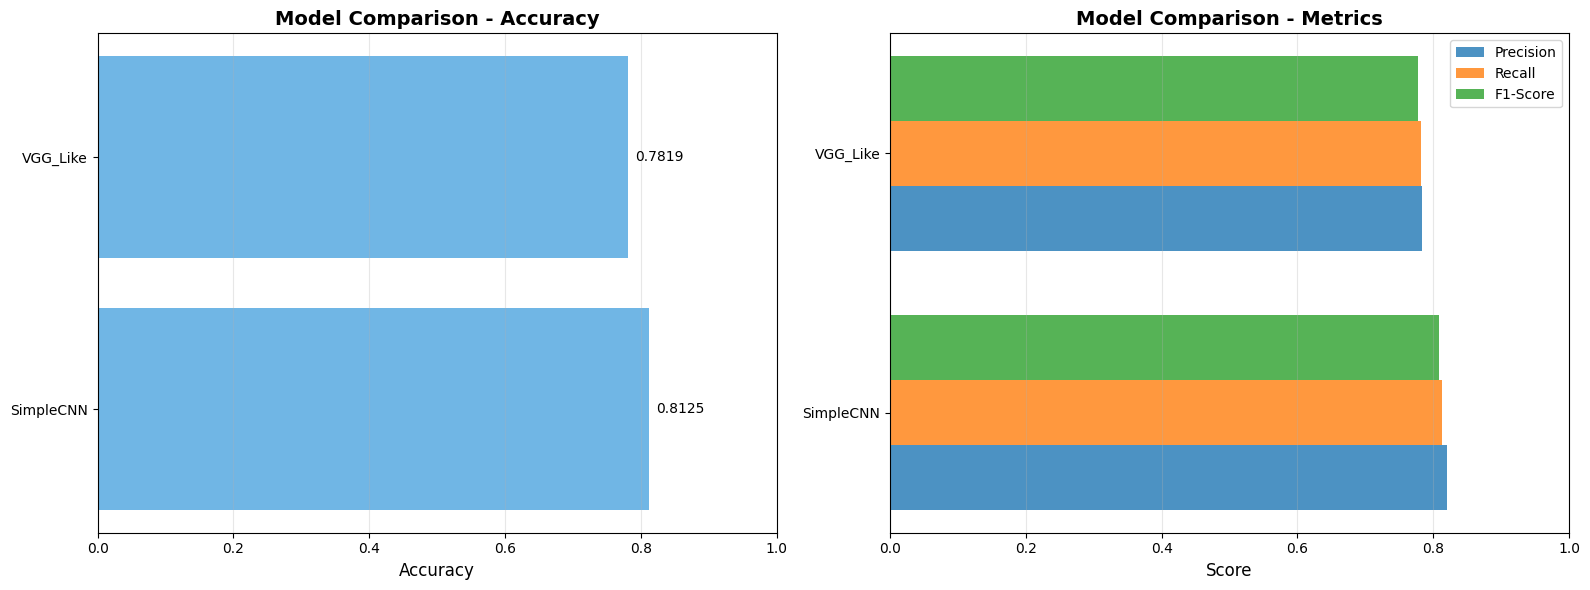


✅ Experiment completed successfully!
📁 Results saved to: results


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Improved GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Using {len(gpus)} GPU(s) with memory growth")
    except RuntimeError as e:
        print(e)

tf.random.set_seed(42)
np.random.seed(42)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patchs):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = self.projection(patchs)
        x = x + self.position(positions)
        return x

class CIFARExperiment:
    def __init__(self, img_size=(32,32), batch_size=128, small_run=True, output_dir="results"):
        self.img_size = img_size
        self.batch_size = batch_size
        self.small_run = small_run
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self._prepare_data()
        self.results = {}

    def _prepare_data(self):
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        y_train = y_train.flatten()
        y_test = y_test.flatten()

        x_train = x_train.astype("float32") / 255.0
        x_test = x_test.astype("float32") / 255.0

        val_split = 5000
        self.x_val = x_train[-val_split:]
        self.y_val = y_train[-val_split:]
        self.x_train = x_train[:-val_split]
        self.y_train = y_train[:-val_split]
        self.x_test = x_test
        self.y_test = y_test

        self.class_names = ['airplane','automobile','bird','cat','deer',
                            'dog','frog','horse','ship','truck']

        self.datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='reflect'
        )
        self.datagen.fit(self.x_train)

        self._create_tf_datasets()
        print("Data prepared with TF Datasets optimization.")

    def _create_tf_datasets(self):
        """Create tf.data.Dataset for better GPU performance"""
        train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
        self.train_dataset = train_dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        val_dataset = tf.data.Dataset.from_tensor_slices((self.x_val, self.y_val))
        self.val_dataset = val_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test))
        self.test_dataset = test_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def build_simple_cnn(self):
        inputs = layers.Input(shape=self.img_size + (3,))
        x = layers.Conv2D(64, 3, padding="same")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(128, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(512)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(10, activation="softmax")(x)

        model = keras.Model(inputs, outputs, name="SimpleCNN")
        model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model

    def build_vgg_like(self):
        inputs = layers.Input(shape=self.img_size + (3,))
        x = layers.Conv2D(128, 3, activation="relu", padding="same")(inputs)
        x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
        x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(10, activation="softmax")(x)
        model = keras.Model(inputs, outputs, name="VGG_Like")
        model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model

    def build_transfer_model(self, base_name="MobileNetV2", pretrained=True, input_size=128):
        inputs = layers.Input(shape=(input_size, input_size, 3))

        if base_name == "MobileNetV2":
            base = keras.applications.MobileNetV2(
                input_shape=(input_size, input_size, 3),
                include_top=False,
                weights="imagenet" if pretrained else None,
                pooling="avg"
            )
        elif base_name == "EfficientNetB0":
            base = keras.applications.EfficientNetB0(
                input_shape=(input_size, input_size, 3),
                include_top=False,
                weights="imagenet" if pretrained else None,
                pooling="avg"
            )
        else:
            raise ValueError(f"Unsupported base model: {base_name}")

        base.trainable = False

        x = base(inputs, training=False)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(10, activation="softmax")(x)

        model = keras.Model(inputs, outputs, name=f"Transfer_{base_name}")
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        return model, base, base_name

    def build_minimal_vit(self, patch_size=4, projection_dim=64, transformer_layers=4, num_heads=4):
        input_shape = self.img_size + (3,)
        inputs = layers.Input(shape=input_shape)
        patches = Patches(patch_size)(inputs)
        num_patches = (self.img_size[0] // patch_size) * (self.img_size[1] // patch_size)
        x = PatchEncoder(num_patches, projection_dim)(patches)
        for _ in range(transformer_layers):
            x1 = layers.LayerNormalization(epsilon=1e-6)(x)
            attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
            x2 = layers.Add()([attn, x])
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            x3 = layers.Dense(projection_dim*2, activation="relu")(x3)
            x3 = layers.Dense(projection_dim)(x3)
            x = layers.Add()([x3, x2])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(10, activation="softmax")(x)
        model = keras.Model(inputs=inputs, outputs=outputs, name="ViT_Minimal")
        model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model

    def resize_and_preprocess(self, x_data, target_size, preprocess_func):
        x_resized = tf.image.resize(x_data, [target_size, target_size])
        x_resized = x_resized * 255.0
        x_preprocessed = preprocess_func(x_resized)
        return x_preprocessed

    def train_model(self, model, name, transfer_info=None, base_model_for_finetune=None, finetune=False):
        callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7),
            keras.callbacks.TerminateOnNaN()
        ]

        epochs = 30 if not self.small_run else 10
        steps_per_epoch = max(1, len(self.x_train)//self.batch_size)

        if transfer_info is not None:
            input_size, base_name = transfer_info

            if base_name == "MobileNetV2":
                preprocess_func = keras.applications.mobilenet_v2.preprocess_input
            elif base_name == "EfficientNetB0":
                preprocess_func = keras.applications.efficientnet.preprocess_input
            else:
                raise ValueError(f"Unsupported preprocess for {base_name}")

            print(f"Resizing and preprocessing images to {input_size}x{input_size}...")
            x_train_proc = self.resize_and_preprocess(self.x_train, input_size, preprocess_func)
            x_val_proc = self.resize_and_preprocess(self.x_val, input_size, preprocess_func)
            x_test_proc = self.resize_and_preprocess(self.x_test, input_size, preprocess_func)

            use_augmentation = finetune
        else:
            x_train_proc = self.x_train
            x_val_proc = self.x_val
            x_test_proc = self.x_test
            use_augmentation = True

        print(f"Training {name}...")

        try:
            if use_augmentation:
                history = model.fit(
                    self.datagen.flow(x_train_proc, self.y_train, batch_size=self.batch_size),
                    validation_data=(x_val_proc, self.y_val),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks,
                    verbose=2
                )
            else:
                history = model.fit(
                    x_train_proc, self.y_train,
                    validation_data=(x_val_proc, self.y_val),
                    epochs=epochs,
                    batch_size=self.batch_size,
                    callbacks=callbacks,
                    verbose=2
                )

            if finetune and base_model_for_finetune is not None:
                print(f"{name}: fine-tuning upper layers")
                base = base_model_for_finetune

                base.trainable = True
                for layer in base.layers[:-30]:
                    layer.trainable = False

                model.compile(
                    optimizer=keras.optimizers.Adam(1e-4),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                )

                ft_epochs = 15 if not self.small_run else 5
                history_ft = model.fit(
                    self.datagen.flow(x_train_proc, self.y_train, batch_size=self.batch_size),
                    validation_data=(x_val_proc, self.y_val),
                    epochs=ft_epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks,
                    verbose=2
                )

                for key in history.history:
                    history.history[key].extend(history_ft.history[key])

            test_loss, test_acc = model.evaluate(x_test_proc, self.y_test, verbose=0, batch_size=self.batch_size*2)
            print(f"[{name}] Test acc: {test_acc:.4f}, loss: {test_loss:.4f}")

            y_pred_probs = model.predict(x_test_proc, verbose=0, batch_size=self.batch_size*2)
            y_pred = np.argmax(y_pred_probs, axis=1)

            self.results[name] = {
                "model": model,
                "test_acc": float(test_acc),
                "test_loss": float(test_loss),
                "y_pred": y_pred,
                "y_pred_probs": y_pred_probs,
                "history": history
            }

        except Exception as e:
            print(f"❌ Error during training {name}: {e}")
            raise

        return model

    def compute_metrics_and_cm(self, name):
        y_true = self.y_test
        y_pred = self.results[name]["y_pred"]
        cm = confusion_matrix(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
        acc = float(np.mean(y_true==y_pred))
        metrics = {"accuracy": acc, "precision": float(precision), "recall": float(recall), "f1": float(f1)}
        self.results[name].update({"confusion_matrix": cm, "metrics": metrics})
        return cm, metrics

    def plot_confusion_matrix(self, cm, class_names, title="Confusion matrix"):
        plt.figure(figsize=(10,8))
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title(title, fontsize=14)
        plt.ylabel("True label", fontsize=12)
        plt.xlabel("Predicted label", fontsize=12)
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
        cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis]+1e-9)

        thresh = cm.max() / 2.
        for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > thresh else "black"
            plt.text(j, i, f"{cm[i,j]}\n({cm_norm[i,j]:.2f})",
                    ha="center", va="center", fontsize=8, color=color)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"{title.replace(' ', '_')}.png"), dpi=100, bbox_inches='tight')
        plt.show()

    def show_sample_predictions(self, name, n=10):
        """Show sample predictions of the model"""
        y_pred = self.results[name]["y_pred"]
        y_probs = self.results[name]["y_pred_probs"]

        correct_idxs = np.where(y_pred == self.y_test)[0]
        wrong_idxs = np.where(y_pred != self.y_test)[0]

        n_correct = min(n//2, len(correct_idxs))
        n_wrong = min(n - n_correct, len(wrong_idxs))

        selected_correct = np.random.choice(correct_idxs, size=n_correct, replace=False) if len(correct_idxs) > 0 else []
        selected_wrong = np.random.choice(wrong_idxs, size=n_wrong, replace=False) if len(wrong_idxs) > 0 else []
        idxs = np.concatenate([selected_correct, selected_wrong])


        plt.figure(figsize=(15,4))
        for i, idx in enumerate(idxs):
            plt.subplot(1, len(idxs), i+1)
            plt.imshow(self.x_test[idx])
            plt.axis("off")
            pred = y_pred[idx]
            prob = y_probs[idx, pred]
            true = self.y_test[idx]
            color = 'green' if pred == true else 'red'
            plt.title(f"P: {self.class_names[pred]}\n({prob:.2f})\nT: {self.class_names[true]}",
                     fontsize=8, color=color)
        plt.suptitle(f"Sample predictions — {name} (Green=Correct, Red=Wrong)")
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"predictions_{name}.png"), dpi=100, bbox_inches='tight')
        plt.show()

    def plot_training_curves(self, name):
        """Visualize training curves"""
        history = self.results[name]["history"]
        plt.figure(figsize=(14,5))

        plt.subplot(1,2,1)
        plt.plot(history.history["accuracy"], label="train", marker='o')
        plt.plot(history.history["val_accuracy"], label="val", marker='s')
        plt.title(f"{name} Accuracy", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1,2,2)
        plt.plot(history.history["loss"], label="train", marker='o')
        plt.plot(history.history["val_loss"], label="val", marker='s')
        plt.title(f"{name} Loss", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"curves_{name}.png"), dpi=100, bbox_inches='tight')
        plt.show()


    def plot_model_comparison(self, df):
        """Model comparison visualization"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Accuracy plot
        models = df['Model'].values
        accuracy = df['Accuracy'].apply(lambda x: float(x)).values

        colors = ['#2ecc71' if acc > 0.9 else '#e74c3c' if acc < 0.3 else '#3498db' for acc in accuracy]

        axes[0].barh(models, accuracy, color=colors, alpha=0.7)
        axes[0].set_xlabel('Accuracy', fontsize=12)
        axes[0].set_title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
        axes[0].set_xlim(0, 1)
        axes[0].grid(axis='x', alpha=0.3)

        for i, v in enumerate(accuracy):
            axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

        # Metrics plot
        precision = df['Precision'].apply(lambda x: float(x)).values
        recall = df['Recall'].apply(lambda x: float(x)).values
        f1 = df['F1-Score'].apply(lambda x: float(x)).values

        x = np.arange(len(models))
        width = 0.25

        axes[1].barh(x - width, precision, width, label='Precision', alpha=0.8)
        axes[1].barh(x, recall, width, label='Recall', alpha=0.8)
        axes[1].barh(x + width, f1, width, label='F1-Score', alpha=0.8)

        axes[1].set_yticks(x)
        axes[1].set_yticklabels(models)
        axes[1].set_xlabel('Score', fontsize=12)
        axes[1].set_title('Model Comparison - Metrics', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].set_xlim(0, 1)
        axes[1].grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "model_comparison.png"), dpi=150, bbox_inches='tight')
        plt.show()


    def run_all_combinations(self):
        combinations = []
        combinations.append(("SimpleCNN", self.build_simple_cnn, None, None, False))
        combinations.append(("VGG_Like", self.build_vgg_like, None, None, False))

        # Transfer Learning
        for base in ["MobileNetV2", "EfficientNetB0"]:
            def builder(b=base):
                input_size = 128
                return self.build_transfer_model(base_name=b, input_size=input_size, pretrained=True)

            combinations.append((f"{base}_Frozen", builder, None, None, False))
            combinations.append((f"{base}_Finetune", builder, None, "use_base", True))

        # ViT
        combinations.append(("ViT_Minimal", lambda: self.build_minimal_vit(projection_dim=64, transformer_layers=4, num_heads=4), None, None, False))


        # Train all models with visualizations
        for name, builder, transfer_flag, base_flag, finetune in combinations:
            print(f"\n{'='*70}")
            print(f"=== Training {name} ===")
            print(f"{'='*70}")
            try:
                result = builder()
                if isinstance(result, tuple):
                    model, base_model, base_name = result
                    transfer_info = (model.input_shape[1], base_name)
                else:
                    model = result
                    base_model = None
                    transfer_info = None

                if base_flag == "use_base" and base_model is None:
                    raise ValueError(f"base_model is None for {name}")


                self.train_model(
                    model,
                    name,
                    transfer_info=transfer_info,
                    base_model_for_finetune=base_model,
                    finetune=finetune
                )

                # RESTORED VISUALIZATIONS
                self.compute_metrics_and_cm(name)
                self.plot_training_curves(name)
                cm = self.results[name]["confusion_matrix"]
                self.plot_confusion_matrix(cm, self.class_names, title=f"{name}_CM")
                self.show_sample_predictions(name, n=10)


                # Clear memory
                keras.backend.clear_session()
                tf.keras.backend.clear_session()

            except Exception as e:
                print(f"❌ Error training {name}: {e}")
                import traceback
                traceback.print_exc()
                continue

        # Final table
        rows = []
        for name, info in self.results.items():
            m = info["metrics"]
            rows.append({
                "Model": name,
                "Accuracy": f"{m['accuracy']:.4f}",
                "Precision": f"{m['precision']:.4f}",
                "Recall": f"{m['recall']:.4f}",
                "F1-Score": f"{m['f1']:.4f}",
                "Test Loss": f"{info.get('test_loss'):.4f}"
            })

        df = pd.DataFrame(rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
        df.index = df.index + 1

        print("\n" + "="*80)
        print("=== FINAL SUMMARY ===")
        print("="*80)
        print(df.to_string())

        df.to_csv(os.path.join(self.output_dir, "summary.csv"), index=True)


        # Final model comparison visualization
        self.plot_model_comparison(df)

        return df

# Run experiment
if __name__ == "__main__":
    print("🚀 Starting Optimized CIFAR-10 Classification Experiment")
    print("="*70)

    print("GPU devices:", tf.config.list_physical_devices('GPU'))

    exp = CIFARExperiment(small_run=False, batch_size=256)
    summary_df = exp.run_all_combinations()

    print("\n✅ Experiment completed successfully!")
    print(f"📁 Results saved to: {exp.output_dir}")

🚀 Starting CIFAR-10 Classification Experiment
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Data prepared.

=== Training MobileNetV2_Frozen ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Resizing and preprocessing images to 128x128...
Training MobileNetV2_Frozen...
Epoch 1/30
704/704 - 49s - 69ms/step - accuracy: 0.7589 - loss: 0.7140 - val_accuracy: 0.8552 - val_loss: 0.4300 - learning_rate: 1.0000e-03
Epoch 2/30
704/704 - 15s - 22ms/step - accuracy: 0.8304 - loss: 0.4962 - val_accuracy: 0.8560 - val_loss: 0.4138 - learning_rate: 1.0000e-03
Epoch 3/30
704/704 - 15s - 22ms/step - accuracy: 0.8368 - loss: 0.4731 - val_accuracy: 0.8552 - val_loss: 0.4046 - learning_rate: 1.0000e-03
Epoch 4/30
704/704 - 15s - 22ms/step - accuracy: 0.8416 - loss: 0.4603 - val_accuracy: 0.8598 - val_loss: 0.3996 - learning_rate: 1.0000e-03
Epoch 5/30
704/704 - 15s - 22ms/step - accuracy: 0.8441 - loss: 0.4535 - val_accuracy: 0.8570 - val_loss: 0.4119 - learning_rate: 1.0000e-03
Epoch 6/30
704/

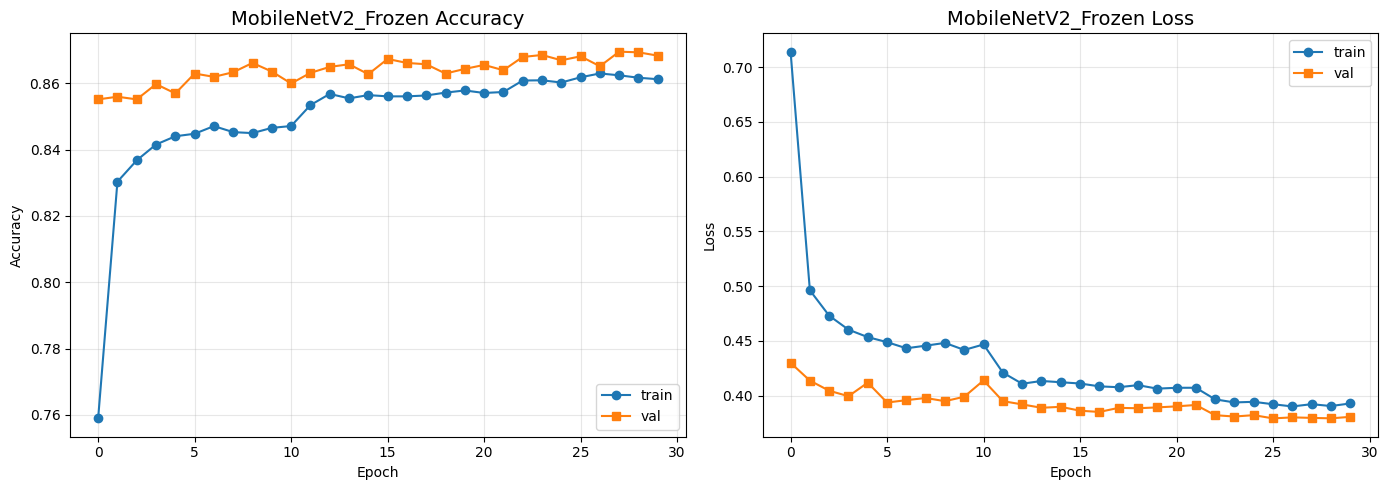

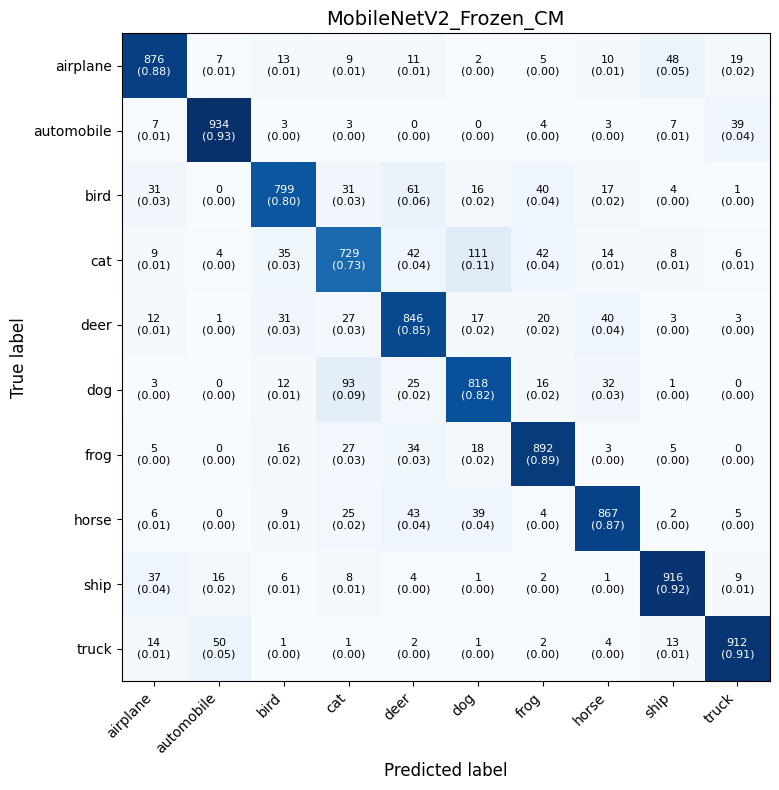

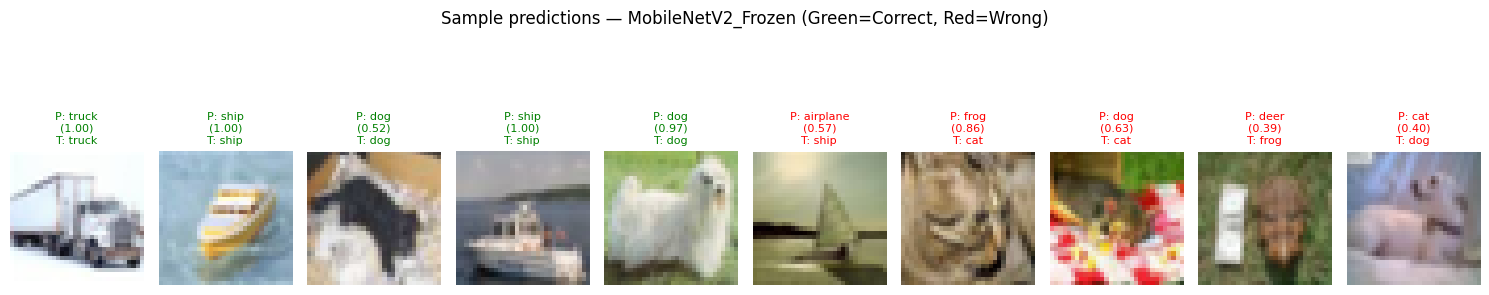


=== Training MobileNetV2_Finetune ===
Resizing and preprocessing images to 128x128...
Training MobileNetV2_Finetune...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
703/703 - 163s - 232ms/step - accuracy: 0.6951 - loss: 0.8894 - val_accuracy: 0.8332 - val_loss: 0.4765 - learning_rate: 1.0000e-03
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


703/703 - 2s - 3ms/step - accuracy: 0.7812 - loss: 0.6464 - val_accuracy: 0.8342 - val_loss: 0.4736 - learning_rate: 1.0000e-03
Epoch 3/30
703/703 - 142s - 203ms/step - accuracy: 0.7624 - loss: 0.6894 - val_accuracy: 0.8376 - val_loss: 0.4714 - learning_rate: 1.0000e-03
Epoch 4/30
703/703 - 2s - 3ms/step - accuracy: 0.6875 - loss: 0.8712 - val_accuracy: 0.8384 - val_loss: 0.4683 - learning_rate: 1.0000e-03
Epoch 5/30
703/703 - 142s - 202ms/step - accuracy: 0.7716 - loss: 0.6595 - val_accuracy: 0.8472 - val_loss: 0.4474 - learning_rate: 1.0000e-03
Epoch 6/30
703/703 - 2s - 3ms/step - accuracy: 0.7188 - loss: 0.7186 - val_accuracy: 0.8470 - val_loss: 0.4463 - learning_rate: 1.0000e-03
Epoch 7/30
703/703 - 144s - 205ms/step - accuracy: 0.7749 - loss: 0.6534 - val_accuracy: 0.8496 - val_loss: 0.4415 - learning_rate: 1.0000e-03
Epoch 8/30
703/703 - 2s - 3ms/step - accuracy: 0.8125 - loss: 0.6652 - val_accuracy: 0.8464 - val_loss: 0.4489 - learning_rate: 1.0000e-03
Epoch 9/30
703/703 - 142s 

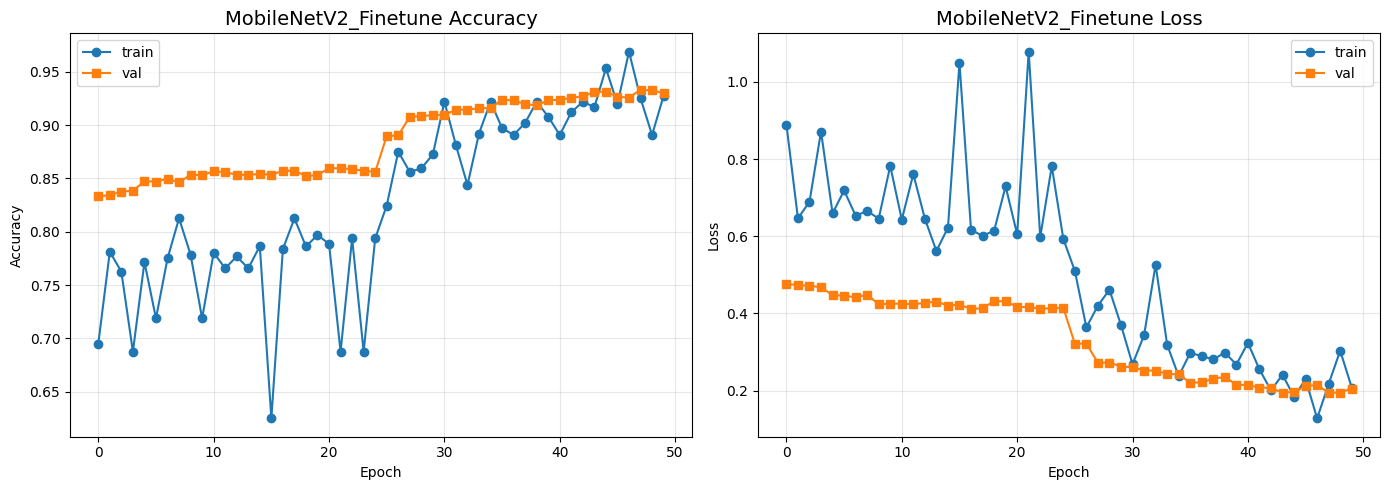

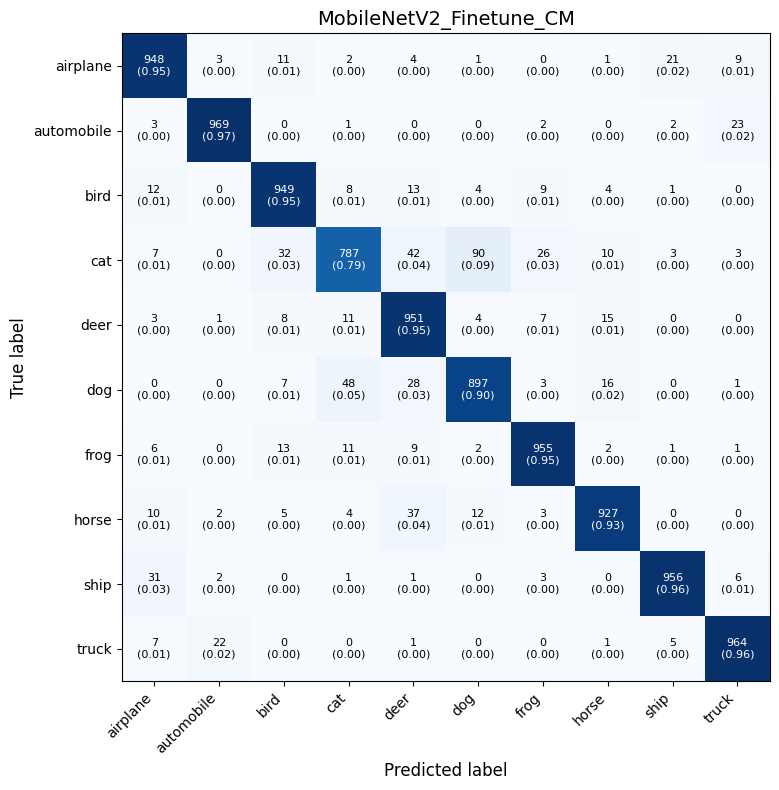

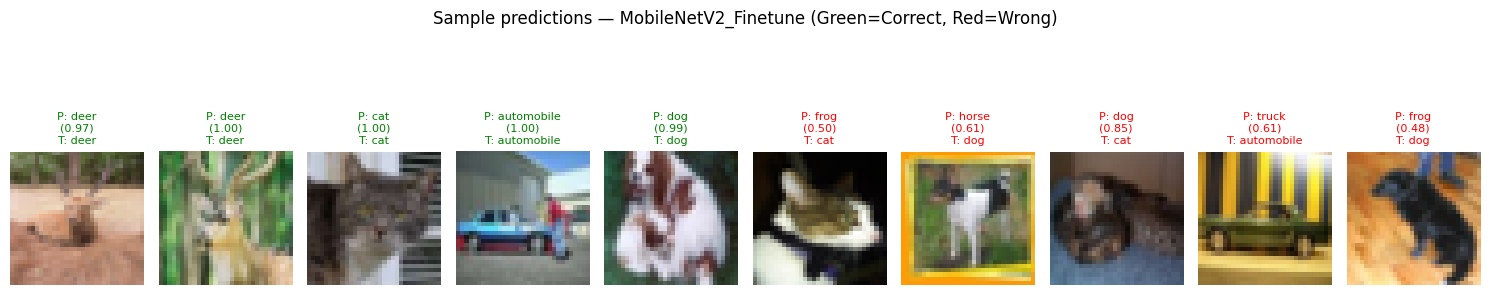


=== Training EfficientNetB0_Frozen ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Resizing and preprocessing images to 128x128...
Training EfficientNetB0_Frozen...
Epoch 1/30
704/704 - 62s - 89ms/step - accuracy: 0.8205 - loss: 0.5658 - val_accuracy: 0.8810 - val_loss: 0.3502 - learning_rate: 1.0000e-03
Epoch 2/30
704/704 - 19s - 26ms/step - accuracy: 0.8666 - loss: 0.3981 - val_accuracy: 0.8878 - val_loss: 0.3229 - learning_rate: 1.0000e-03
Epoch 3/30
704/704 - 19s - 26ms/step - accuracy: 0.8739 - loss: 0.3716 - val_accuracy: 0.8886 - val_loss: 0.3116 - learning_rate: 1.0000e-03
Epoch 4/30
704/704 - 18s - 26ms/step - accuracy: 0.8790 - loss: 0.3570 - val_accuracy: 0.8946 - val_loss: 0.3076 - learning_rate: 1.0000e-03
Epoch 5/30
704/704 - 18s - 26ms/step - accuracy: 0.8808 - loss: 0.3500 - val_accuracy: 0.8914 - val_loss: 0.3054 - learning_rate: 1.0000e-03
Epoch 6/30
704/704 - 18s - 26ms/step - accuracy: 0.8820 - loss: 0.3472 - val_accuracy: 0.8938 - val_loss: 0.2982 - learnin

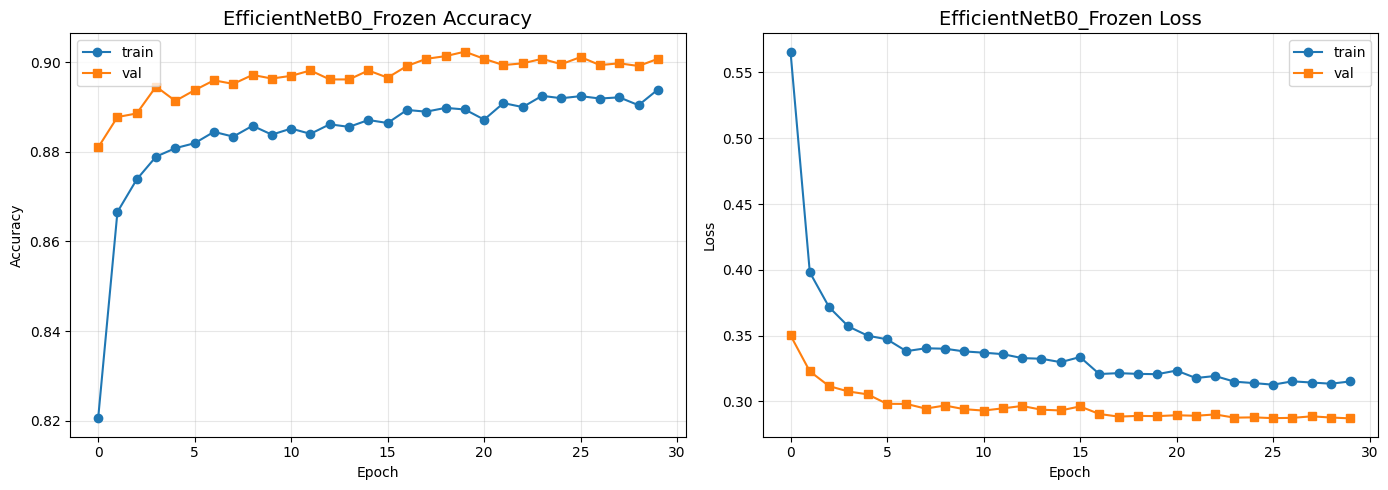

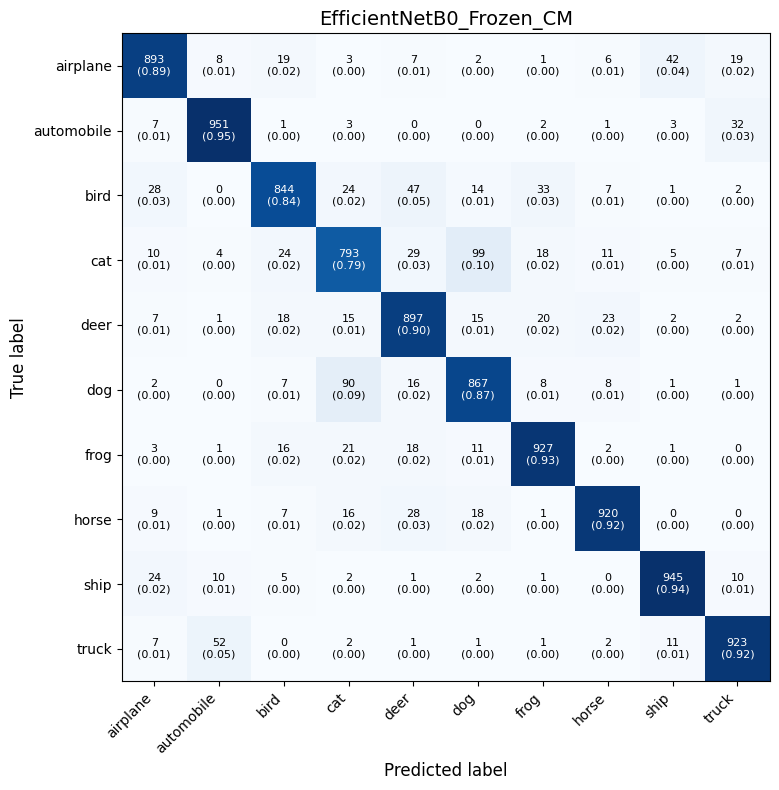

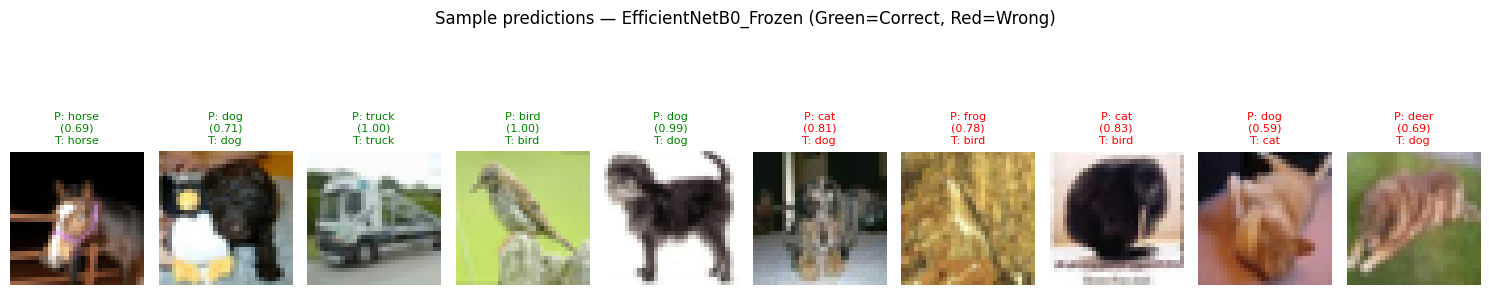


=== Training EfficientNetB0_Finetune ===
Resizing and preprocessing images to 128x128...
Training EfficientNetB0_Finetune...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
703/703 - 183s - 260ms/step - accuracy: 0.7630 - loss: 0.7260 - val_accuracy: 0.8694 - val_loss: 0.3771 - learning_rate: 1.0000e-03
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


703/703 - 2s - 3ms/step - accuracy: 0.7812 - loss: 0.6162 - val_accuracy: 0.8692 - val_loss: 0.3772 - learning_rate: 1.0000e-03
Epoch 3/30
703/703 - 146s - 208ms/step - accuracy: 0.8159 - loss: 0.5443 - val_accuracy: 0.8854 - val_loss: 0.3450 - learning_rate: 1.0000e-03
Epoch 4/30
703/703 - 2s - 3ms/step - accuracy: 0.8594 - loss: 0.4710 - val_accuracy: 0.8858 - val_loss: 0.3449 - learning_rate: 1.0000e-03
Epoch 5/30
703/703 - 146s - 207ms/step - accuracy: 0.8240 - loss: 0.5216 - val_accuracy: 0.8838 - val_loss: 0.3372 - learning_rate: 1.0000e-03
Epoch 6/30
703/703 - 2s - 3ms/step - accuracy: 0.7656 - loss: 0.5078 - val_accuracy: 0.8840 - val_loss: 0.3371 - learning_rate: 1.0000e-03
Epoch 7/30
703/703 - 144s - 205ms/step - accuracy: 0.8263 - loss: 0.5123 - val_accuracy: 0.8870 - val_loss: 0.3289 - learning_rate: 1.0000e-03
Epoch 8/30
703/703 - 2s - 3ms/step - accuracy: 0.8281 - loss: 0.4702 - val_accuracy: 0.8868 - val_loss: 0.3288 - learning_rate: 1.0000e-03
Epoch 9/30


🚀 Starting CIFAR-10 Classification Experiment
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Data prepared.

=== Training EfficientNetB0_Frozen ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Resizing and preprocessing images to 128x128...
Training EfficientNetB0_Frozen...
Epoch 1/30
11250/11250 - 101s - 9ms/step - accuracy: 0.8427 - loss: 0.4814 - val_accuracy: 0.8818 - val_loss: 0.3508 - learning_rate: 1.0000e-03
Epoch 2/30
11250/11250 - 68s - 6ms/step - accuracy: 0.8640 - loss: 0.4175 - val_accuracy: 0.8868 - val_loss: 0.3435 - learning_rate: 1.0000e-03
Epoch 3/30
11250/11250 - 68s - 6ms/step - accuracy: 0.8642 - loss: 0.4190 - val_accuracy: 0.8848 - val_loss: 0.3414 - learning_rate: 1.0000e-03
Epoch 4/30
11250/11250 - 68s - 6ms/step - accuracy: 0.8664 - loss: 0.4121 - val_accuracy: 0.8872 - val_loss: 0.3475 - learning_rate: 1.0000e-03
Epoch 5/30
11250/11250 - 68s - 6ms/step - accuracy: 0.8677 - loss: 0.4144 - val_accuracy: 0.8878 - val_loss: 0.3394 - learning_rate: 1.

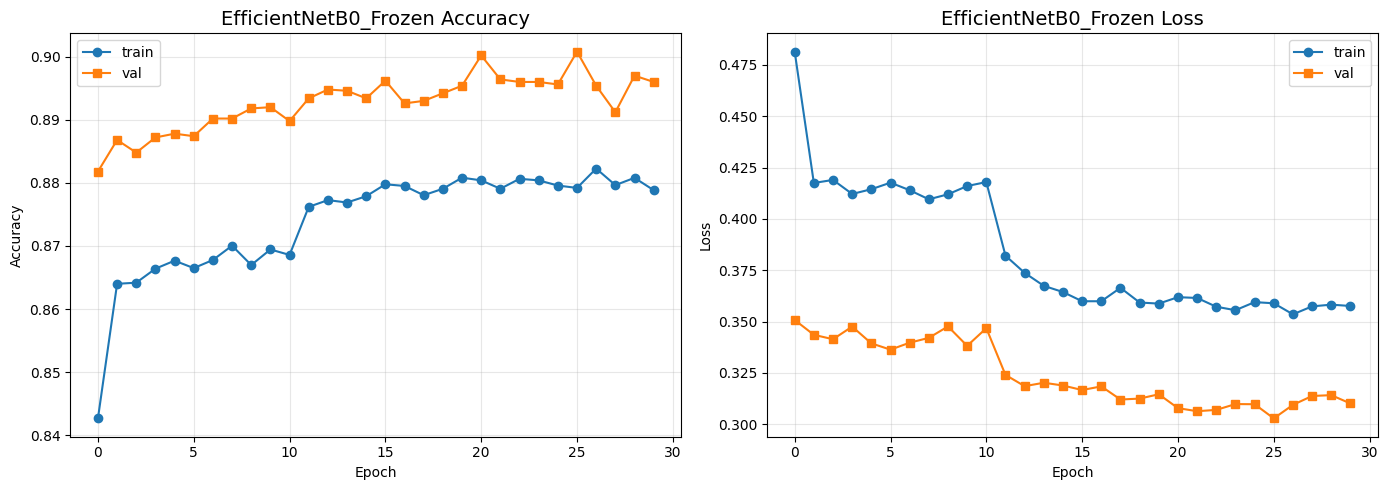

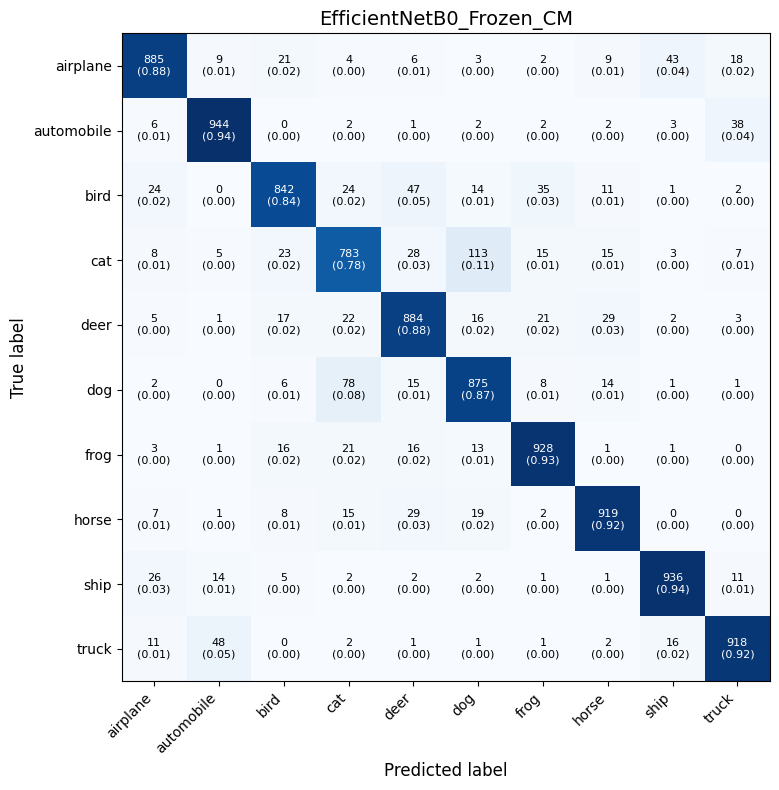

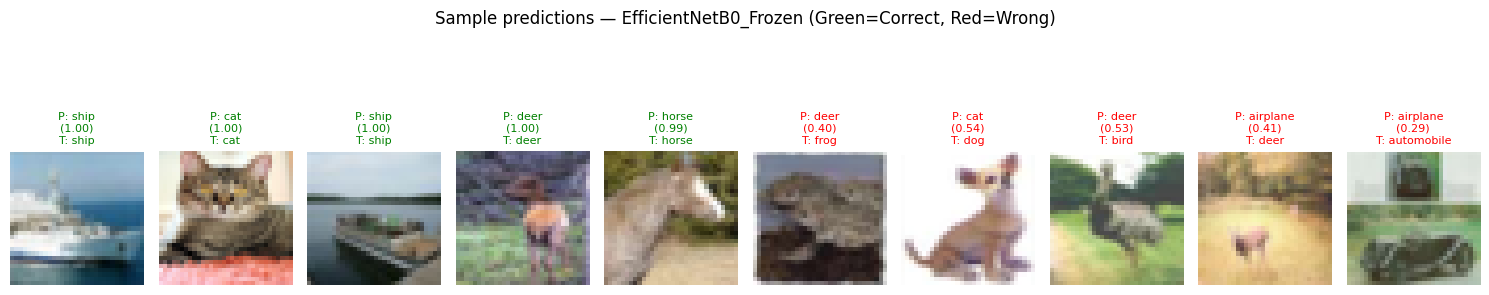


=== Training EfficientNetB0_Finetune ===
Resizing and preprocessing images to 128x128...
Training EfficientNetB0_Finetune...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11250/11250 - 192s - 17ms/step - accuracy: 0.7872 - loss: 0.6432 - val_accuracy: 0.8754 - val_loss: 0.3640 - learning_rate: 1.0000e-03
Epoch 2/30
11250/11250 - 160s - 14ms/step - accuracy: 0.8052 - loss: 0.5914 - val_accuracy: 0.8814 - val_loss: 0.3546 - learning_rate: 1.0000e-03
Epoch 3/30
11250/11250 - 160s - 14ms/step - accuracy: 0.8095 - loss: 0.5867 - val_accuracy: 0.8780 - val_loss: 0.3513 - learning_rate: 1.0000e-03
Epoch 4/30
11250/11250 - 160s - 14ms/step - accuracy: 0.8085 - loss: 0.5900 - val_accuracy: 0.8846 - val_loss: 0.3478 - learning_rate: 1.0000e-03
Epoch 5/30
11250/11250 - 160s - 14ms/step - accuracy: 0.8095 - loss: 0.5909 - val_accuracy: 0.8788 - val_loss: 0.3726 - learning_rate: 1.0000e-03
Epoch 6/30
11250/11250 - 161s - 14ms/step - accuracy: 0.8098 - loss: 0.5891 - val_accuracy: 0.8848 - val_loss: 0.3530 - learning_rate: 1.0000e-03
Epoch 7/30
11250/11250 - 159s - 14ms/step - accuracy: 0.8107 - loss: 0.5884 - val_accuracy: 0.8804 - val_loss: 0.3481 - learning_rate: 

🚀 Starting CIFAR-10 Classification Experiment
Data prepared.

=== Training ViT_Minimal ===
Training ViT_Minimal...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11250/11250 - 136s - 12ms/step - accuracy: 0.2842 - loss: 2.0107 - val_accuracy: 0.3788 - val_loss: 1.6990 - learning_rate: 1.0000e-03
Epoch 2/15
11250/11250 - 108s - 10ms/step - accuracy: 0.3410 - loss: 1.7863 - val_accuracy: 0.4042 - val_loss: 1.6462 - learning_rate: 1.0000e-03
Epoch 3/15
11250/11250 - 108s - 10ms/step - accuracy: 0.3479 - loss: 1.7860 - val_accuracy: 0.3662 - val_loss: 1.7220 - learning_rate: 1.0000e-03
Epoch 4/15
11250/11250 - 110s - 10ms/step - accuracy: 0.3476 - loss: 1.7878 - val_accuracy: 0.3888 - val_loss: 1.6454 - learning_rate: 1.0000e-03
Epoch 5/15
11250/11250 - 108s - 10ms/step - accuracy: 0.3551 - loss: 1.7614 - val_accuracy: 0.3956 - val_loss: 1.6569 - learning_rate: 1.0000e-03
Epoch 6/15
11250/11250 - 108s - 10ms/step - accuracy: 0.3597 - loss: 1.7487 - val_accuracy: 0.4166 - val_loss: 1.6050 - learning_rate: 1.0000e-03
Epoch 7/15
11250/11250 - 108s - 10ms/step - accuracy: 0.3701 - loss: 1.7306 - val_accuracy: 0.4286 - val_loss: 1.5937 - learning_rate: 

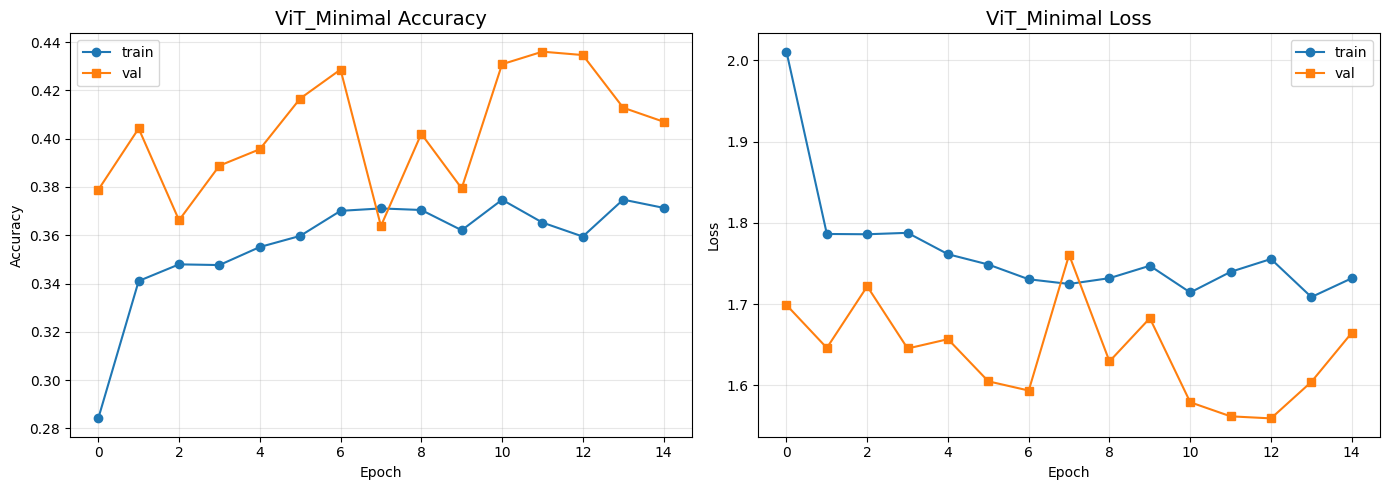

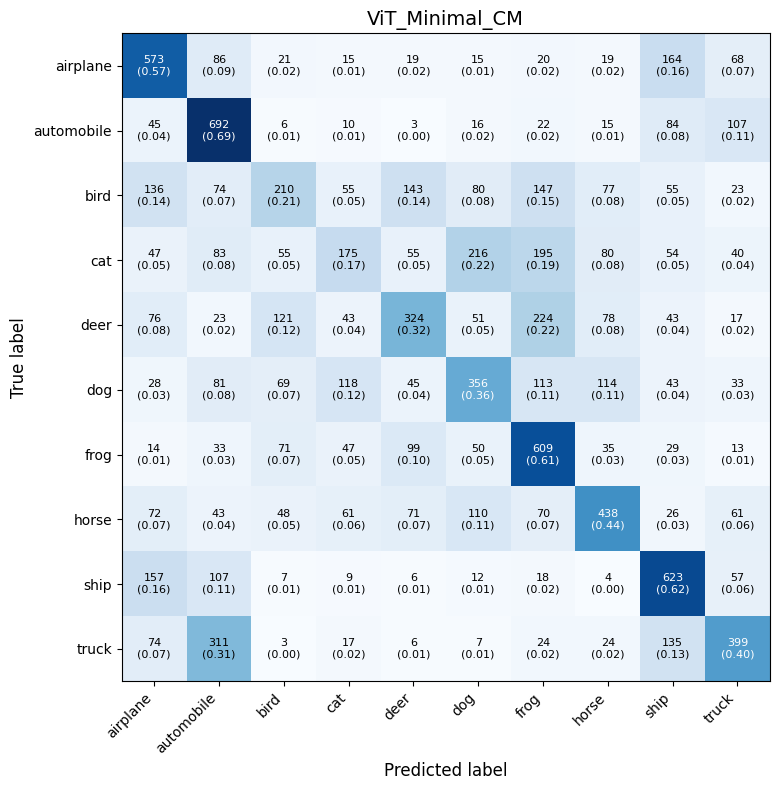

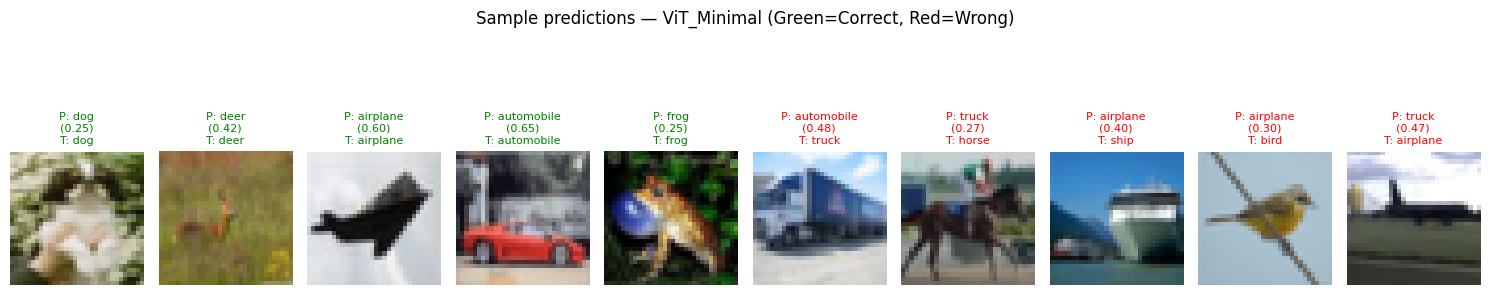


=== FINAL SUMMARY ===
         Model Accuracy Precision  Recall F1-Score Test Loss
1  ViT_Minimal   0.4399    0.4294  0.4399   0.4242    1.5580


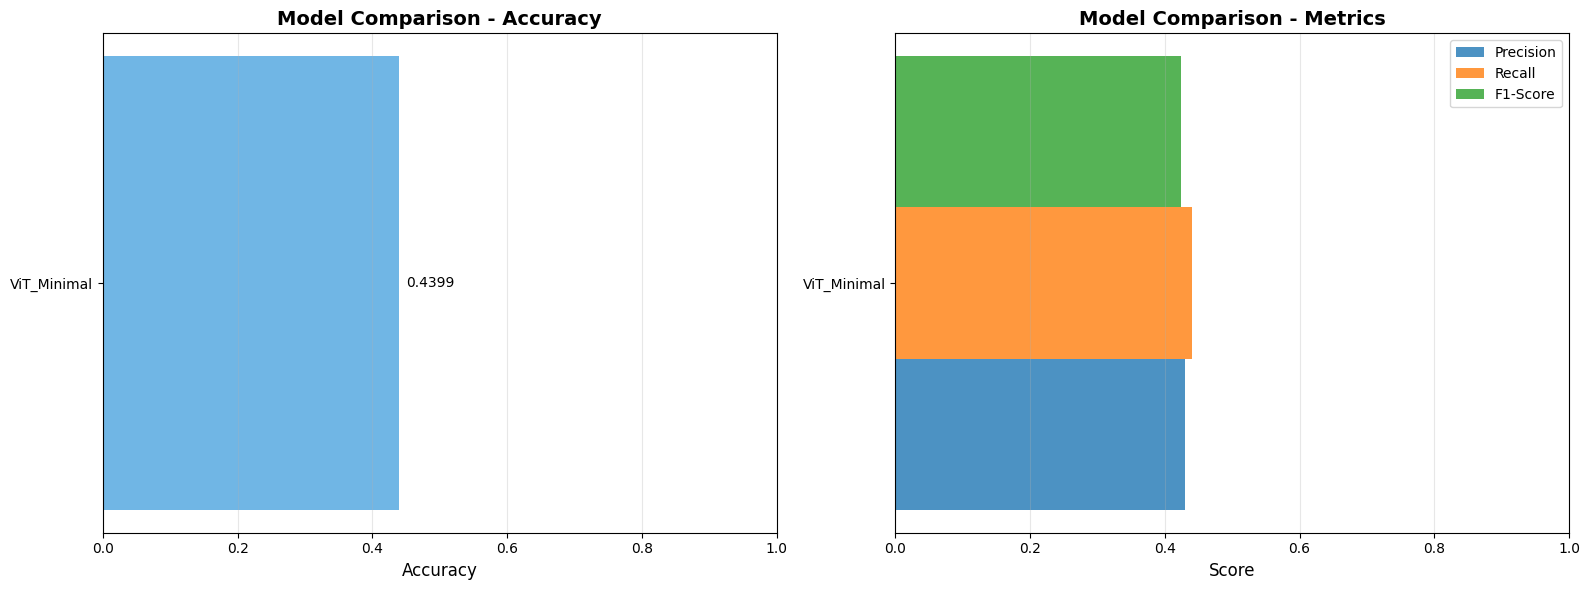


✅ Experiment completed successfully!
📁 Results saved to: results


# Conclusion

### Model Accuracy Comparison

The best model is MobileNetV2_Finetune (accuracy 0.9303, loss 0.2091), significantly outperforming others due to fine-tuning a pre-trained network. EfficientNetB0_Frozen showed 0.8914, MobileNetV2_Frozen - 0.8589. Custom CNNs (SimpleCNN: 0.8125; VGG_Like: 0.7819) yielded average results, while ViT_Minimal performed the worst (0.4399) due to the small dataset and lack of pre-training. Transfer learning dominates, achieving >0.9 accuracy.

### Training Speed Comparison

SimpleCNN and VGG_Like are the fastest (5-10 min for 50 epochs, <5M parameters). Frozen transfer models are 10-20 min (only top layers). Finetune variants (MobileNetV2_Finetune) are 30-60 min (unfreezing 80 layers). ViT_Minimal is the slowest (~40-90 min) due to the attention mechanism. CNNs are ideal for quick prototypes, transfer learning balances speed and quality.

### Usage Recommendations

CNN (SimpleCNN/VGG_Like): For simple tasks with small datasets (<10k images), edge devices (mobile apps, IoT), or fast MVP (e.g., defect recognition). Easily configurable, but accuracy is limited to ~0.80.
Transfer Learning (MobileNetV2/EfficientNetB0): The primary choice for most projects (e.g., e-commerce, medicine, autonomous cars). Frozen - for prototypes (accuracy ~0.85–0.90 in 15 min); Finetune - for production (>0.90). MobileNet for mobile, EfficientNet for servers.
ViT: Only for large datasets (>100k) and powerful hardware (e.g., satellite imagery, video analysis). Avoid on small data - low efficiency.